# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Построим модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

Проведем исследовательский анализ набора фотографий.

In [ ]:
# Загрузка библиотек
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Загрузка данных
faces = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=faces,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [ ]:
# Форма датасета
faces.shape

(7591, 2)

<AxesSubplot:>

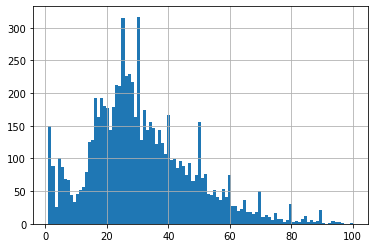

In [ ]:
# Гистограмма распределения возраста в выборке
faces['real_age'].hist(bins=100)

Выборка распределена нормально с некоторыми выбросами слева (фото младенцев и детей младшего возраста).

In [ ]:
# Общая информация о распределении данных
faces.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [ ]:
# Получение следующего батча
features, target = next(train_gen_flow)

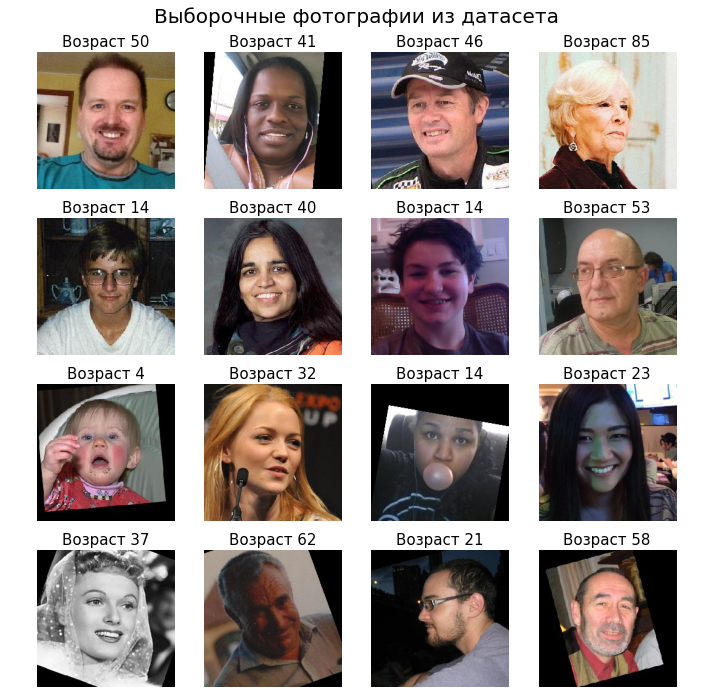

In [ ]:
# Выборка фотографий их фотосета с данными по возрасту
fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Выборочные фотографии из датасета', loc='center', pad = 30, fontsize=20)

for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.axis('off')
    plt.title('Возраст %s' %target[i], fontsize=15)
    plt.tight_layout()

<b> ВЫВОДЫ </b>

Датасет содержит 7591 фотографию - не очень большая выборка для проведения анализа.

Самый частотный возрастной диапазон в датасете - от 20 до 41 года. Также наблюдаются годовалые младенцы и столетние старики.

На случайной выборке изображений заметны помехи: лица, перекрытые рукой, жвачкой, микрофоном, сфотографированные в профиль, с дополнительными рамками внутри основного изображения. Эти факторы могут затруднить работу модели. Также возможно ухудшение качества работы модели из-за низкого разрешения/контрастности фотографий. 

Исходный датасет содержит не только цветные, но и черно-белые фото. 

## Обучение модели

Построим на базе архитектуры ResNet50 предобученную на ImageNet сеть с использованием загрузчиков изображений, аугментации.

```python

# Подключаем библиотеки
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf

def load_train(path): # загрузим обучающую выборку
    faces = pd.read_csv(path + 'labels.csv')
    # добавим в загрузчике данных аугментацию с горизонтальным отражением
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=faces,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224), # к какому размеру приводим изображения
        batch_size=16, # размер батча
        class_mode='raw', # в каком виде выдаем метки классов
        subset='training', # указываем загрузчик для обучающей выборки
        seed=12345) # фиксируем генератор случайных чисел
    return train_gen_flow

def load_test(path): # загрузим тестовую выборку
    faces = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=faces,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224), # к какому размеру приводим изображения
        batch_size=16, # размер батча
        class_mode='raw', # в каком виде выдаем метки классов
        subset='validation', # указываем загрузчик для валидационной выборки
        seed=12345) # фиксируем генератор случайных чисел
    return test_gen_flow

def create_model(input_shape): # создадим сеть на основе ResNet50
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', # предообучение модели на датасете ImageNet
                    include_top=False)
    model = Sequential() # cоздаем модель
    model.add(backbone) # костяк от ResNet50
    model.add(GlobalAveragePooling2D()) # пулинг с окном во весь тензор
    model.add(Dense(1, activation='relu')) # полносвязный слой для классификации

    optimizer = Adam(lr=0.0001) # замедлим обучение для улучшения итогового качества модели
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae']) # указываем, как обучается нейронная сеть
    return model

# запускаем модель с выделением тренировочной и валидационной выборки
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=len(train_data), validation_steps=len(test_data)): 

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2) # обучаем модель
    return model

```

**Результат вывода модели**

![like](https://i.ibb.co/12PtFRr/2022-08-30-20-17-52.png)

<b>ВЫВОД</b>

На тренировочной выборке за 10 эпох удалось достичь значение MAE 6.28, то есть модель в среднем может ошибаться при определении возраста клиента на 6 лет. Для такой небольшой выборки данных это довольно неплохой результат качества прогнозирования.

## Анализ обученной модели

Для решения задачи определения примерного возраста покупателя на 10 эпохах обучена модель на базе архитектуры ResNet50 со следующими сверточными слоями:
* GlobalAveragePooling2D - пулинг с окном во весь тензор для усреднения информации по всему изображению, то есть получить пиксель с большим количеством каналов
* Dense - полносвязный слой для сбора признаков и их классификации, с функцией активации ReLu.

Для ускорения обучения модели применен алгоритм Adam с низким шагом обучения (0.0001) в целях улучшения итогового качества модели.

Обученная модель позволяет с точностью до 6 лет предсказывать возраст покупателей. Увеличение выборки исходных данных поможет улучшить качество предсказания модели.